In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
from scipy.constants import *
from scipy.optimize import curve_fit
from uncertainties import ufloat
plt.rc('axes', prop_cycle=(cycler('color', list('rbgm')) +
                           cycler('linestyle', ['-', '-.', ':', '--'])))

def preetyPlot(ax):
    [tick.label.set_fontsize(19) for tick in ax.xaxis.get_major_ticks()]
    [tick.label.set_fontsize(19) for tick in ax.yaxis.get_major_ticks()]
    ax.set_xlabel('$t(\mu s)$', fontsize=20)
    ax.set_ylabel('Number of events', fontsize=20)
    plt.legend(loc=0, fontsize=19)

From Wikipedia, the Bethe-Bloch formula is given by 
$$- \left\langle\frac{dE}{dx}\right\rangle = \frac{4 \pi}{m_e c^2} \frac{nz^2}{\beta^2}\left(\frac{e^2}{4\pi\varepsilon_0}\right)^2 \left[\ln \left(\frac{2m_e c^2 \beta^2}{I  (1-\beta^2)}\right) - \beta^2\right]$$

where $n = \frac{N_AZ\rho}{A}$ and $I_{Cu}/Z_{Cu} = 11 eV$, $I_{C}/Z_{C} = 15 eV$.

In [2]:
def electronDensity(Z, rho, A):
    return N_A * Z * rho /(A*1.)

def betheBlochFormula(n, z, I, beta = 0.9998):
    toreturn = 4*np.pi/(m_e*c**2) * n*z**2 /(beta**2) * (e**2/(4*np.pi*epsilon_0))**2\
    * (np.log(2*m_e*c**2*beta**2/(I*(1-beta**2)))-beta**2)
    return -1*toreturn

In [3]:
copper_density = 8920. #kg/m3
plastic_density = 940. #kg/m3  Low/High density Polyethilene
copper_I = 11*29*e #Joules
plastic_I = 15*6*e #Joules
copper_elec_dens = electronDensity(29, copper_density, 63.54)
plastic_elec_dens = electronDensity(6, plastic_density, 12)

In [4]:
print 'For Cu', -betheBlochFormula(copper_elec_dens, 1, copper_I)/e *1e-6, 'MeV'
print 'For C (Plastic)', -betheBlochFormula(plastic_elec_dens, 1, plastic_I)/e *1e-6, 'MeV'

For Cu 1.86298756486643 MeV
For C (Plastic) 0.23334606184953993 MeV


# Compute $\lambda_1$

In [5]:
t1 = 2.4e3# mus
lambda1 = t1**-1
print lambda1
def Z4Law(Z):
    lambda_capture_z = lambda1*Z**4
    tau_capture_z = lambda_capture_z**-1
    return tau_capture_z
print Z4Law(29)
lifetimes_neg_matter = np.array([2.4e3, 25., 1.5, .22, .09])
Zs = np.array([1, 6, 13, 26, 82.])
rates_neg_matter = 1./lifetimes_neg_matter
print rates_neg_matter/(Zs**4)

0.000416666666667
0.00339327650538
[4.16666667e-04 3.08641975e-05 2.33418531e-05 9.94681240e-06
 2.45754841e-07]


# Initial calibration with unknown threshold

In [6]:
import pandas as pd
from scipy import stats
from scipy.optimize import fsolve


In [7]:
raw_data = pd.read_excel('Calib_PMT_2.xlsx')
display(raw_data)
def extract_data(r_data, PMT_num):
    PMT_data = r_data[r_data['PMT']==PMT_num]
    PMT_data = PMT_data.drop('PMT', axis=1)
    PMT_data = PMT_data.set_index(PMT_data['Voltage (kV)'])
    PMT_data = PMT_data.sort_values('Voltage (kV)')
    PMT_matrix = PMT_data.as_matrix()
    return PMT_matrix

,PMT,Voltage (kV),Counts (60s)
0,1,2.01,1814
1,2,2.00,535
2,2,2.05,1005
3,1,2.05,2550
4,1,2.10,5007
5,2,2.10,1957
6,1,2.15,7575
7,2,2.15,3108
8,1,2.20,12723
9,2,2.20,5202


In [8]:
matrices = [extract_data(raw_data, i) for i in range(1, 5)]

In [9]:
def line(x, m, b, des):
    return m*x + b - des

def get_calibrating_voltage(PMT_matrix, desired_count, pmt, marker='o', linestyle='-', color='r'):
    V_data = PMT_matrix[:,0]
    count_data = PMT_matrix[:,1]
    log_count_data = np.log(count_data)
    V_mask=[v<=2.3 and v>=2 for v in V_data]
    V_data = V_data[V_mask]
    log_count_data = log_count_data[V_mask]
    plt.plot(V_data, log_count_data, label = 'PMT %i'%pmt, marker=marker, markersize=8, lw=0, c=color)
    plt.xlabel('$V(kV)$', fontsize=19)
    plt.ylabel('$\ln N(a.u.)$', fontsize=19)
    slope, intercept, r_value, p_value, std_err = stats.linregress(V_data, log_count_data)
    plt.plot(np.linspace(2, 2.4, 100), slope*np.linspace(2, 2.4, 100)+intercept, ls = linestyle, c=color)
    #print slope, intercept
    plt.legend()
    return fsolve(line, 2, (slope, intercept, desired_count))
    

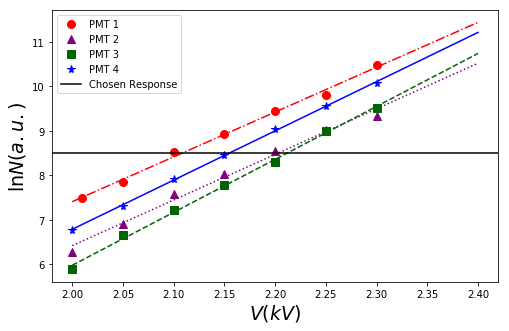

In [10]:
plt.figure(figsize=(8,5))
markers = ['o', '^', 's', '*']
linestyles = ['-.', ':', '--', '-']
colors = ['r', 'purple', 'darkgreen', 'b']
resV = [(i+1,get_calibrating_voltage(matrix, 8.5, i+1, marker=markers[i], linestyle=linestyles[i], color=colors[i])[0]) for i, matrix in enumerate(matrices)]
plt.axhline(8.5, c='k', label='Chosen Response')
plt.legend()
plt.gcf()
plt.savefig('PMTCalib.png', dpi=300)

In [11]:
for t in resV:
    print '%i & %.2f \\\\'%t

1 & 2.11 \\
2 & 2.20 \\
3 & 2.21 \\
4 & 2.15 \\


# Calibración Threshold

    Threshold (V)  Counts (10s) source  Counts (10s) no source
31           0.29                84670                   16311
30           1.07                53838                    8590
29           1.22                46825                    6775
28           1.43                39568                    5306
27           1.64                34844                    4272
26           1.83                32054                    3568
25           1.98                30379                    3238
24           2.11                28973                    3148
23           2.25                27921                    2838
22           2.38                26928                    2648
21           2.60                25892                    2624
20           2.70                25353                    2384
19           2.89                24518                    2173
18           3.03                24256                    2073
17           3.19                23269                 

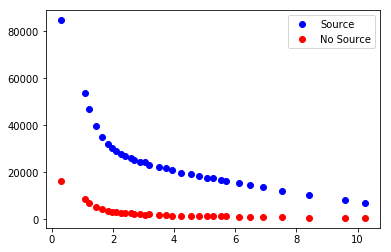

In [12]:
raw_data = pd.read_excel('Threshold_calib.xlsx')
raw_data= raw_data.sort_values('Threshold (V)')
mat = raw_data.as_matrix()
plt.plot(mat[:,0], mat[:,1], 'ob', label='Source')
plt.plot(mat[:,0], mat[:,2], 'or', label='No Source')
plt.legend(loc=0)
print raw_data

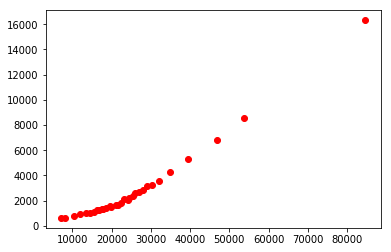

In [13]:
plt.plot(mat[:,1], mat[:,2], 'or', label='Source vs. No Source')

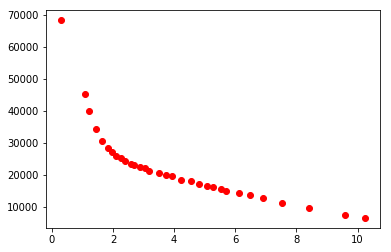

In [14]:
plt.plot(mat[:,0], mat[:,1]-mat[:,2], 'or', label='Source - No Source')


+ Compton scattering: Relation between incoming photon and electron energy
+ Muon decay products' energy
+ More precise threshold measurements


In [15]:
def electron_E(E_gamma):
    return E_gamma*(1-1./(1+2*(E_gamma/(511e-3))))

In [16]:
gamma_energies = [1.17, 1.33] #Cobalt
gamma_Co = [electron_E(E) for E in gamma_energies]
print 'Co', gamma_Co, 'MeV'

gamma_energies = [0.032, 0.662] #Cs
gamma_Cs = [electron_E(E) for E in gamma_energies]
print 'Cs', gamma_Cs, 'MeV'

Co [0.9602946334619431, 1.115673289183223] MeV
Cs [0.003561739130434784, 0.47765013623978203] MeV


# Cumulative Spectrum

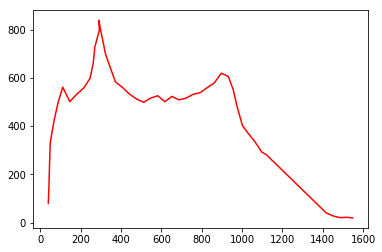

In [17]:
from scipy import interpolate
spectrum = np.loadtxt('Co_Spectrum.csv', delimiter =',')
def cumulate_spectrum(spectrum):
    evaluate_spectrum = interpolate.interp1d(spectrum[:,0], spectrum[:,1], kind='cubic')
    x = np.linspace(spectrum[:,0][0], spectrum[:,0][-1], 100)
plt.plot(spectrum[:,0], spectrum[:,1])

In [18]:
#This function can either print or store the markov chain. For parallel computing it is easier to print.
def MH_Spectrum_Sampling(spectrum, niter):
    evaluate_spectrum = interpolate.interp1d(spectrum[:,0], spectrum[:,1])
    markov_chain=[]
    max_interval=spectrum[:,0][-1]
    initial_value=max_interval*np.random.random()
    #print initial_value
    markov_chain.append(initial_value)
    for i in range(niter):
        std = 10**(np.log10(spectrum[:,0][-1]))
        to_try = np.random.normal(markov_chain[i], std)
        while(to_try<spectrum[:,0][0] or to_try>spectrum[:,0][-1]):
            to_try = np.random.normal(markov_chain[i], std)
        possible_jump=to_try
        criteria = evaluate_spectrum(possible_jump)/evaluate_spectrum(markov_chain[i])
        if(criteria>=1.):
            #print abs(possible_jump)
            markov_chain.append(abs(possible_jump))
        else:
            other_random = np.random.random()
            if(other_random<=criteria):
                #print possible_jump
                markov_chain.append(possible_jump)
            else:
                #print markov_chain[i]
                markov_chain.append(markov_chain[i])
    return np.array(markov_chain)

In [19]:
raw_data_Co = pd.read_excel('Threshold_calib.xlsx')

def decumulate_measured_spectrum(raw, kind):
    raw= raw.sort_values('Threshold (V)')
    #display(raw)
    mat = raw.as_matrix()
    measured_spectrum = np.column_stack((mat[:,0], (mat[:,1]-mat[:,2])))
    plt.scatter(measured_spectrum[:,0], measured_spectrum[:,1])
    evaluate_measured_spectrum = interpolate.interp1d(measured_spectrum[:,0], measured_spectrum[:,1], kind = kind)
    th_linsp = np.linspace(0.29, 10.24, 50)
    freqs = evaluate_measured_spectrum(th_linsp)
    intl_cdf = np.trapz(freqs, th_linsp)
    intl_pdf = np.trapz(np.diff(freqs), th_linsp[:-1])

    #freqs = np.copy(measured_spectrum[:,1])
    #th_linsp = np.copy(measured_spectrum[:,0])
    plt.plot(th_linsp, freqs, 'or')
    #plt.plot(th_linsp, (np.gradient(freqs)))

    #uncumulated = [freqs[i]-freqs[i+1] for i in range(len(freqs)-1)]
    uncumulated = np.diff(freqs)
    return th_linsp[:-1], freqs[:-1]/intl_cdf, uncumulated/intl_pdf

Text(0.5,1,u'Co')

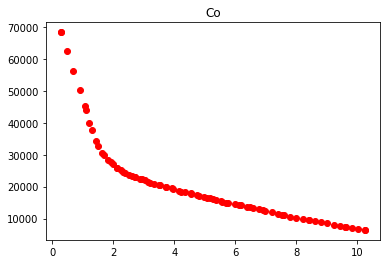

In [20]:
x, ysp, y = decumulate_measured_spectrum(raw_data_Co, 'linear')
plt.title('Co')

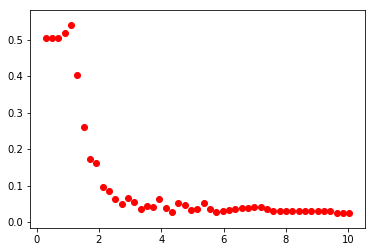

In [21]:
#%matplotlib notebook
plt.scatter(x, y)

plt.plot(x, y)

Text(0.5,1,u'Cs')

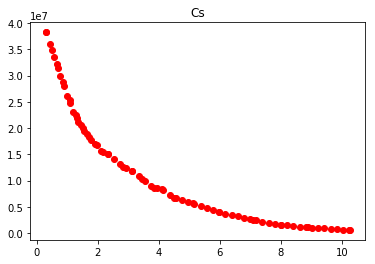

In [22]:
raw_data_Cs = pd.read_excel('Threshold_calib_Cs.xlsx')
x_Cs, ysp_Cs, y_Cs = decumulate_measured_spectrum(raw_data_Cs, 'linear')
plt.title('Cs')

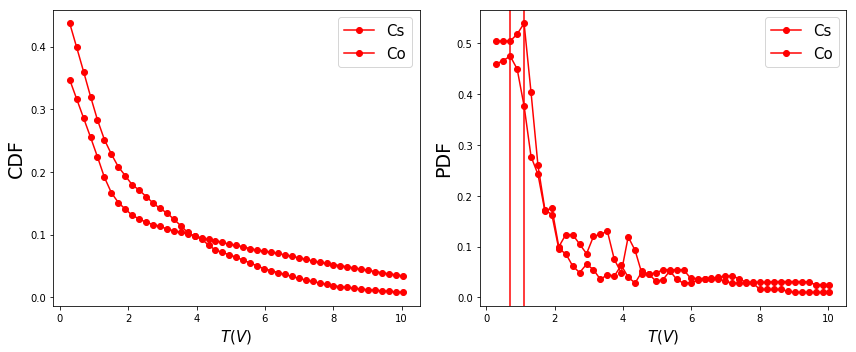

In [23]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].plot(x_Cs, ysp_Cs, 'o-', label = 'Cs')
ax[0].plot(x, ysp, 'or-', label = 'Co')
ax[1].plot(x_Cs, y_Cs, 'o-', label = 'Cs')
ax[1].plot(x, y, 'or-', label = 'Co')
th_Co, = x[y==max(y)]
ax[1].axvline(th_Co, c = 'r')
th_Cs, = x_Cs[y_Cs==max(y_Cs)]
ax[1].axvline(th_Cs, c = 'C0')

[a.set_xlabel('$T (V)$', fontsize =15) for a in ax]
ax[0].set_ylabel('CDF', fontsize=19)
ax[1].set_ylabel('PDF', fontsize=19)

[a.legend(fontsize = 15) for a in ax]
plt.tight_layout()
plt.gcf()
plt.savefig('th_calibration.png', dpi = 300)

[0.47765013623978203, 0.9602946334619431]
[0.6961224489795919, 1.1022448979591837]


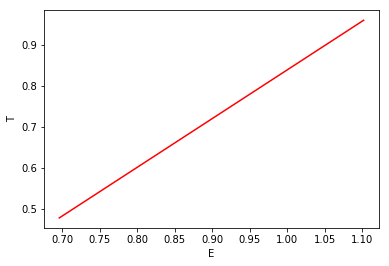

In [24]:
energies = [gamma_Cs[1], gamma_Co[0]]
print energies
threshold = [th_Cs, th_Co]
print threshold
plt.plot(threshold, energies)
plt.xlabel('E')
plt.ylabel('T')
slope, intercept, r_value, p_value, std_err = stats.linregress(energies, threshold)

In [25]:
print slope*4.5+intercept

4.080739049241165


In [26]:
slope, intercept, r_value, p_value, std_err = stats.linregress(threshold, energies)

In [27]:
print slope*4.5+intercept

4.998258570271873


# N-th "good" measurement $N\rightarrow\infty$

In [29]:
#Background estimation
data_stop = np.loadtxt('Muons2018/muon2wTOPnoB--00000.txt',  delimiter = ';', skiprows = 5, dtype=float)
data_sbottom = np.loadtxt('Muons2018/muon2wBOTTOMnoB--00000.txt' , delimiter = ';', skiprows = 5, dtype=float)

[4.00e-08 2.40e-07 4.40e-07 6.40e-07 8.40e-07 1.04e-06 1.24e-06 1.44e-06
 1.64e-06 1.84e-06 2.04e-06 2.24e-06 2.44e-06 2.64e-06 2.84e-06 3.04e-06
 3.24e-06 3.44e-06 3.64e-06 3.84e-06 4.04e-06 4.24e-06 4.44e-06 4.64e-06
 4.84e-06 5.04e-06 5.24e-06 5.44e-06 5.64e-06 5.84e-06 6.04e-06 6.24e-06
 6.44e-06 6.64e-06 6.84e-06 7.04e-06 7.24e-06 7.44e-06 7.64e-06 7.84e-06
 8.04e-06 8.24e-06 8.44e-06 8.64e-06 8.84e-06 9.04e-06 9.24e-06 9.44e-06
 9.64e-06 9.84e-06 1.00e-05 1.02e-05 1.04e-05]
23


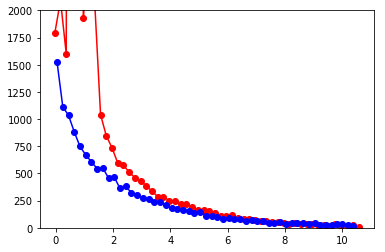

In [30]:
x_top = data_stop[:,0]
y_top = data_stop[:,1]
x_bottom = data_sbottom[:,0]
y_bottom = data_sbottom[:,1]
dummy_y_top = np.copy(y_top)
dummy_y_bottom = np.copy(y_bottom)
x_top=x_top[y_top != 0]
y_top=y_top[y_top != 0]

x_bottom=x_bottom[y_bottom != 0]
y_bottom=y_bottom[y_bottom != 0]
delta = (x_bottom[-1]-x_bottom[0])/len(x_bottom)
upper = 15e-6
N = (upper-x_bottom[0])/delta
print x_bottom
ext_x_bottom =  np.linspace(x_bottom[0], upper, int(N))
#pad interpolation range with zeros
#ext_y_top = np.pad(y_top, len(ext_x_bottom)-len(x_top), mode='constant')
#ext_y_bottom = np.pad(y_bottom, len(ext_x_bottom)-len(x_bottom), mode='constant')

plt.plot(x_top*1e6, y_top, 'o-')
plt.plot(x_bottom*1e6, y_bottom, 'o-')
plt.ylim(0,2000)
print len(ext_x_bottom)-len(x_bottom)

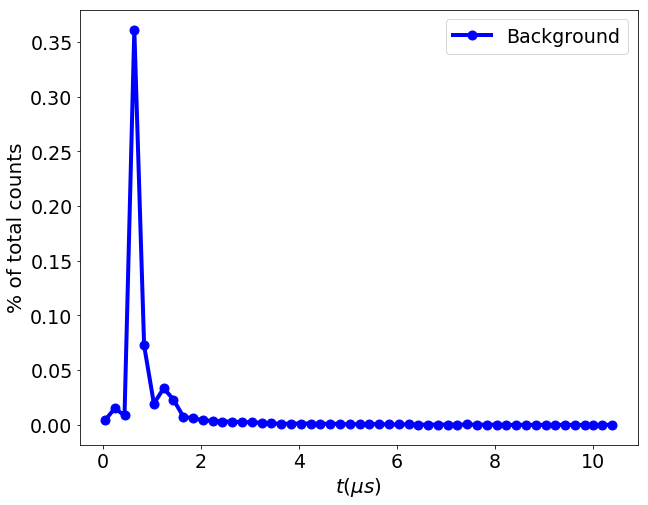

In [31]:
bkg_y = (y_top[:-1]-y_bottom)
bkg_y /=(sum(y_top[:-1]+y_bottom))
#bkg_y /=(sum(y_top[:-1]))
ext_bkg_y = np.pad(bkg_y, (1,len(ext_x_bottom)-len(x_bottom)), mode='constant')
ext_x_bottom = np.pad(ext_x_bottom, (1,0), mode='constant')
fig, ax = plt.subplots(1,1, figsize=(10,8))

plt.plot(x_bottom*1e6, bkg_y, 'ob-',label='Background', linewidth=4, markersize=9)
#plt.plot(ext_x_bottom*1e6, ext_bkg_y)
bkg_interpF = interpolate.interp1d(ext_x_bottom, ext_bkg_y, kind='nearest')
#t = np.linspace(x_bottom[0], x_bottom[-1], 100)
#plt.plot(t*1e6, bkg_interpF(t))
preetyPlot(plt.gca())
ax.set_ylabel('% of total counts')
#ax.set_yscale('log')
plt.gcf()
plt.savefig('Background.png', dpi=300)

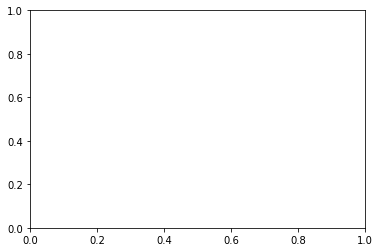

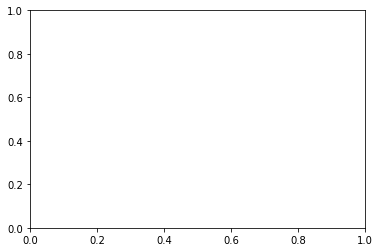

In [32]:


def f(x, a, t, b):
    return a *np.exp(-x/t) + b

def removeBackgroundPeaks(bkg, data_x, data_y, n):
    for i in range(n):
        ind = np.where(bkg == max(bkg))
        data_x = np.delete(data_x, ind)
        data_y = np.delete(data_y, ind)
        bkg = np.delete(bkg, ind)
    return data_x, data_y

def chisq(data, fit, params):
    deg = len(data)-params
    return sum((data-fit)**2/fit)/deg
def doTheFit(data, th=0, f =f, guess = [2000., (2.2e-6),1], ax=plt.figure().gca(), removeBkg = 5):
    th+=2
    y =data[th:,1]
    sy = sum(y)
    x= data[th:,0]
    scale =1.
    dummy_y = np.copy(y)
    y=y[abs(dummy_y)!=0]
    x=x[abs(dummy_y)!=0]
    print x, y
    bkg = sy*bkg_interpF(x)/scale
    

    
    '''    
    if subs_bkg == True:
        y = np.copy(y)- bkg
        removeBkg = 0
#        ax.plot(x, bkg, 'og')'''
    
    x, y = removeBackgroundPeaks(bkg, x, y, removeBkg)
    print 'The number of counts is %i'%(sum(y*scale))
    popt, pcov = curve_fit(f, x, y, guess)
    perr = np.sqrt(np.diag(pcov))
    chisqd = chisq(y, f(x, *popt), len(guess))
    print 'Parameters: ', popt
    t = np.linspace(x[0], x[-1], 100)
    #print 'The muon lifetime obtained is %.3f mus'%(-popt[1]**-1 * 1e6)
    #print 'The background level is estimated to be %.2f of the total'%popt[-1]
    ax.plot(t*1e6, f(t, *popt), label = '$t>%.2f\mu s\ \ \\tau = %.3f\pm%.3f\mu s$\n$\chi^2/$dof$=%.2f$'%(x[0]*1e6, popt[1] * 1e6,abs(perr[1]) * 1e6, chisqd), lw = 5)
    ax.plot(x*1e6,y, 'ok')

    #ax.plot(t, popt[0]*np.exp(-t/(2.2e-6))+popt[-1])
    #ax.plot(t, popt[0]*np.exp(-t/(0.15e-6))+popt[-1])
    #print 'The errors in the fit are ', perr
    print 'Chi sq = %.3f'%chisqd
    [tick.label.set_fontsize(19) for tick in ax.xaxis.get_major_ticks()]
    [tick.label.set_fontsize(19) for tick in ax.yaxis.get_major_ticks()]
    ax.set_xlabel('$t(\mu s)$', fontsize=20)
    ax.set_ylabel('Number of events', fontsize=20)
    return popt[1]
    
def doTheDoubleFit(data, th=0, f =f, guess = [2000.,2000., 2.2e-6, 0.16e-6,20], ax=plt.figure().gca(), removeBkg=5):
    def f(x, a,c, tp, tm, b):
        return a*np.exp(-x/tp) + c*np.exp(-x/tm) + b
    th+=2
    y =data[th:,1]
    sy = sum(y)
    x= data[th:,0]
    dummy_y = np.copy(y)
    y=y[abs(dummy_y)!=0]
    x=x[abs(dummy_y)!=0]
    #print x
    scale =1.
    bkg = sy*bkg_interpF(x)/scale

    x, y = removeBackgroundPeaks(bkg, x, y, removeBkg)
    print 'The number of counts is %i'%(sum(y*scale))
    popt, pcov = curve_fit(f, x, y, guess, bounds=([0, 0, 0, 0, 0], [np.inf,np.inf, np.inf, np.inf, np.inf]))
    print pcov
    perr = np.sqrt(np.diag(pcov))    
    chisqd = chisq(y, f(x, *popt), len(guess))
    print 'Parameters: ', popt
    t = np.linspace(x[0], x[-1], 100)
    #print 'The positive muon lifetime obtained is %.3f mus'%(-popt[2]**-1 * 1e6)
    #print 'The negative muon lifetime obtained is %.3f mus'%(-popt[3]**-1 * 1e6)

    #print 'The background level is estimated to be %.2f of the total'%popt[-1]
    #ax.plot(x, bkg, 'ok')
    ax.plot(t*1e6, f(t, *popt), label = '$\\tau^+ = %.3f\pm%.3f\mu s$ \n $\\tau^- = %.3f\pm%.3f\mu s$\n$\chi^2/$dof$=%.2f$'%(popt[2] * 1e6, perr[2]*1e6, popt[3] * 1e6, perr[3]*1e6, chisqd), lw = 5)
    ax.plot(x*1e6,y, 'ok', markersize=7)

    #ax.plot(t, popt[0]*np.exp(-t/(2.2e-6))+popt[-1])
    #ax.plot(t, popt[0]*np.exp(-t/(0.15e-6))+popt[-1])
    #print 'The errors in the fit are ', perr
    print 'Chi sq = %.3f'%chisq(y, f(x, *popt), len(guess))
    [tick.label.set_fontsize(19) for tick in ax.xaxis.get_major_ticks()]
    [tick.label.set_fontsize(19) for tick in ax.yaxis.get_major_ticks()]
    ax.set_xlabel('$t(\mu s)$', fontsize=20)
    ax.set_ylabel('Number of events', fontsize=20)

tail_threshold = 10

# Single exponential fit

## Original Top + Bottom data

[2.0e-07 4.0e-07 6.0e-07 8.0e-07 1.0e-06 1.2e-06 1.4e-06 1.6e-06 1.8e-06
 2.0e-06 2.2e-06 2.4e-06 2.6e-06 2.8e-06 3.0e-06 3.2e-06 3.4e-06 3.6e-06
 3.8e-06 4.0e-06 4.2e-06 4.4e-06 4.6e-06 4.8e-06 5.0e-06 5.2e-06 5.4e-06
 5.6e-06 5.8e-06 6.0e-06 6.2e-06 6.4e-06 6.6e-06 6.8e-06 7.0e-06 7.2e-06
 7.4e-06 7.6e-06 7.8e-06 8.0e-06 8.2e-06 8.4e-06 8.6e-06 8.8e-06 9.0e-06
 9.2e-06 9.4e-06 9.6e-06] [ 3033.  2514. 20878.  4797.  2278.  3258.  1865.  1428.  1191.  1092.
   927.   900.   811.   760.   690.   639.   610.   518.   507.   432.
   423.   389.   324.   310.   301.   235.   249.   245.   184.   187.
   192.   137.   129.   136.   130.   112.   104.   117.   113.    63.
    86.    79.    67.    63.    67.    66.    76.    61.]
The number of counts is 20697
Parameters:  [3.18652040e+03 1.83081136e-06 5.98884595e+01]
Chi sq = 2.703
[2.0e-06 2.2e-06 2.4e-06 2.6e-06 2.8e-06 3.0e-06 3.2e-06 3.4e-06 3.6e-06
 3.8e-06 4.0e-06 4.2e-06 4.4e-06 4.6e-06 4.8e-06 5.0e-06 5.2e-06 5.4e-06
 5.6e-06 5.8e-06

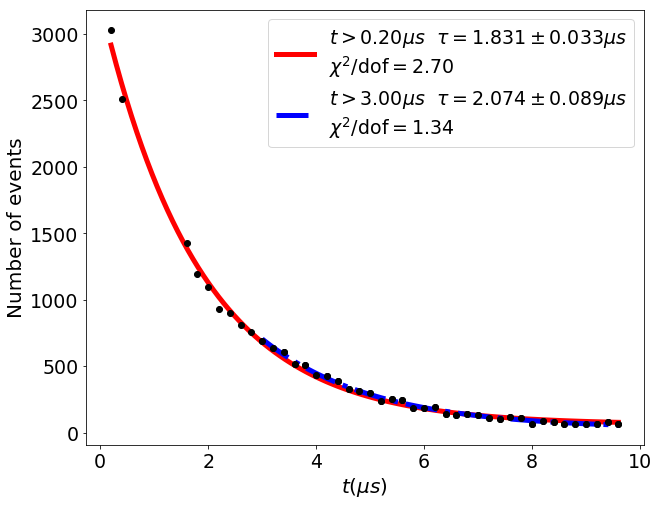

In [33]:
data2weekOK = np.loadtxt('Muons2018/muon2weekOK--00000.txt', delimiter = ';', skiprows = 5)
fig, ax = plt.subplots(1,1, figsize=(10,8))

tau_total = doTheFit(data2weekOK,1, ax=ax)

tau_plus = doTheFit(data2weekOK,tail_threshold, ax=ax)

#print 'The NEGATIVE MUON lifetime obtained is %.3f mu s'%tau_minus
x= np.linspace(1e-7, 10e-6, 1000)

               
#ax.plot(x,5.10259278e+03*np.exp(-x/(2.2e-6)), label = '$\\tau = 2.2 \mu s$', lw=5)
#ax.plot(x,5.10259278e+03*np.exp(-x/(0.15e-6)), label = '$\\tau = 0.15 \mu s$', lw=5)
#ax.plot(x,5.10259278e+03*np.exp(-x*((2.2e-6)**-1 + (0.15e-6)**-1)), label = '$\\tau = total \mu s$', lw=5)
plt.legend(loc=0, fontsize=19)
plt.gcf()
plt.savefig('BothNoBSingleExp.png', dpi=300)

## Just Bottom data

[4.40e-07 6.40e-07 8.40e-07 1.04e-06 1.24e-06 1.44e-06 1.64e-06 1.84e-06
 2.04e-06 2.24e-06 2.44e-06 2.64e-06 2.84e-06 3.04e-06 3.24e-06 3.44e-06
 3.64e-06 3.84e-06 4.04e-06 4.24e-06 4.44e-06 4.64e-06 4.84e-06 5.04e-06
 5.24e-06 5.44e-06 5.64e-06 5.84e-06 6.04e-06 6.24e-06 6.44e-06 6.64e-06
 6.84e-06 7.04e-06 7.24e-06 7.44e-06 7.64e-06 7.84e-06 8.04e-06 8.24e-06
 8.44e-06 8.64e-06 8.84e-06 9.04e-06 9.24e-06 9.44e-06 9.64e-06 9.84e-06
 1.00e-05 1.02e-05 1.04e-05] [1034.  883.  748.  671.  607.  544.  550.  457.  465.  363.  381.  321.
  303.  277.  266.  238.  238.  207.  180.  174.  168.  154.  135.  143.
  113.  112.   96.   85.   87.   84.   82.   67.   69.   59.   62.   44.
   48.   54.   35.   42.   44.   44.   38.   41.   27.   24.   28.   39.
   31.   25.   19.]
The number of counts is 11006
Parameters:  [1.16133821e+03 1.95765057e-06 2.95447753e+01]
Chi sq = 1.592
[2.24e-06 2.44e-06 2.64e-06 2.84e-06 3.04e-06 3.24e-06 3.44e-06 3.64e-06
 3.84e-06 4.04e-06 4.24e-06 4.44e-06 4.64e-

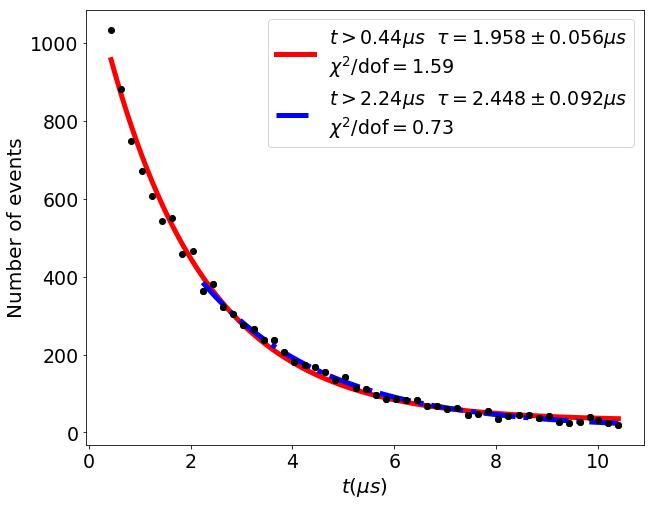

In [34]:
data2weekOK = np.loadtxt('Muons2018/muon2wBOTTOMnoB--00000.txt', delimiter = ';', skiprows = 5)

fig, ax = plt.subplots(1,1, figsize=(10,8))

tau_sing_all = doTheFit(data2weekOK,1, ax=ax, removeBkg=0)
tau_plus = doTheFit(data2weekOK,tail_threshold, ax=ax, removeBkg=0)
#tau_minus = ((1./tau_total) - (1./tau_plus))**-1
#print 'The NEGATIVE MUON lifetime obtained is %.3f mu s'%tau_minus
x= np.linspace(1e-7, 10e-6, 1000)

#ax.plot(x,5.10259278e+03*np.exp(-x/(2.2e-6)), label = '$\\tau = 2.2 \mu s$', lw=5)
#ax.plot(x,5.10259278e+03*np.exp(-x/(0.15e-6)), label = '$\\tau = 0.15 \mu s$', lw=5)
#ax.plot(x,5.10259278e+03*np.exp(-x*((2.2e-6)**-1 + (0.15e-6)**-1)), label = '$\\tau = total \mu s$', lw=5)
plt.legend(loc=0, fontsize=19)
plt.gcf()
plt.savefig('BottomNoBSingleExp.png', dpi=300)

# Double exponential fit

## Original Top + Bottom data

The number of counts is 20697
[[ 6.23787130e+03  7.25723471e+03 -4.42278180e-06 -3.18345099e-06
   4.73935587e+02]
 [ 7.25723471e+03  7.92145732e+04 -4.82631922e-06 -1.14140817e-05
   5.10746248e+02]
 [-4.42278180e-06 -4.82631922e-06  3.77873013e-15  2.25430877e-15
  -5.11141096e-07]
 [-3.18345099e-06 -1.14140817e-05  2.25430877e-15  2.54010660e-15
  -2.53381166e-07]
 [ 4.73935587e+02  5.10746248e+02 -5.11141096e-07 -2.53381166e-07
   9.93619127e+01]]
Parameters:  [2.85435682e+03 1.26143727e+03 2.04402182e-06 1.78064128e-07
 3.42462512e+01]
Chi sq = 1.497
[2.0e-06 2.2e-06 2.4e-06 2.6e-06 2.8e-06 3.0e-06 3.2e-06 3.4e-06 3.6e-06
 3.8e-06 4.0e-06 4.2e-06 4.4e-06 4.6e-06 4.8e-06 5.0e-06 5.2e-06 5.4e-06
 5.6e-06 5.8e-06 6.0e-06 6.2e-06 6.4e-06 6.6e-06 6.8e-06 7.0e-06 7.2e-06
 7.4e-06 7.6e-06 7.8e-06 8.0e-06 8.2e-06 8.4e-06 8.6e-06 8.8e-06 9.0e-06
 9.2e-06 9.4e-06 9.6e-06] [1092.  927.  900.  811.  760.  690.  639.  610.  518.  507.  432.  423.
  389.  324.  310.  301.  235.  249.  245.  184

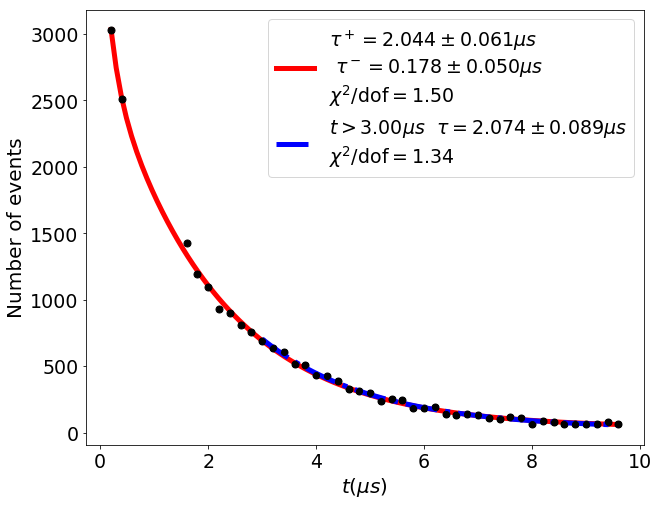

In [35]:
data2weekOK = np.loadtxt('Muons2018/muon2weekOK--00000.txt', delimiter = ';', skiprows = 5)
fig, ax = plt.subplots(1,1, figsize=(10,8))

__ = doTheDoubleFit(data2weekOK,1, ax=ax)
__ = doTheFit(data2weekOK,tail_threshold, ax=ax)
plt.legend(loc=0, fontsize=19)
plt.gcf()
plt.savefig('BothNoBDoubleExp.png', dpi=300)

## Just Bottom data

The number of counts is 11006
[[ 8.68354687e+02  4.91498587e+03 -2.14985343e-06 -1.36569288e-06
   7.88549005e+01]
 [ 4.91498587e+03  7.48465641e+04 -1.04558878e-05 -1.43744955e-05
   3.60458503e+02]
 [-2.14985343e-06 -1.04558878e-05  6.69312391e-15  3.13268199e-15
  -3.18165888e-07]
 [-1.36569288e-06 -1.43744955e-05  3.13268199e-15  3.15197566e-15
  -1.15374253e-07]
 [ 7.88549005e+01  3.60458503e+02 -3.18165888e-07 -1.15374253e-07
   2.13458479e+01]]
Parameters:  [1.00646813e+03 9.80427145e+02 2.31692947e-06 2.69654594e-07
 1.36742284e+01]
Chi sq = 0.757
[2.24e-06 2.44e-06 2.64e-06 2.84e-06 3.04e-06 3.24e-06 3.44e-06 3.64e-06
 3.84e-06 4.04e-06 4.24e-06 4.44e-06 4.64e-06 4.84e-06 5.04e-06 5.24e-06
 5.44e-06 5.64e-06 5.84e-06 6.04e-06 6.24e-06 6.44e-06 6.64e-06 6.84e-06
 7.04e-06 7.24e-06 7.44e-06 7.64e-06 7.84e-06 8.04e-06 8.24e-06 8.44e-06
 8.64e-06 8.84e-06 9.04e-06 9.24e-06 9.44e-06 9.64e-06 9.84e-06 1.00e-05
 1.02e-05 1.04e-05] [363. 381. 321. 303. 277. 266. 238. 238. 207. 180. 17

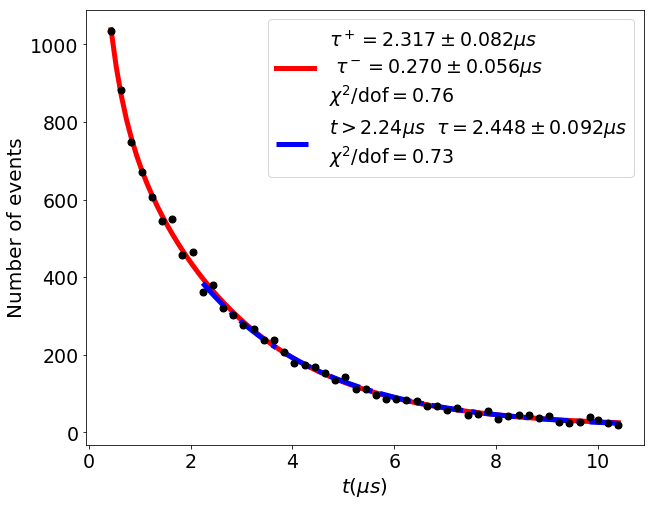

In [36]:
data2weekOK = np.loadtxt('Muons2018/muon2wBOTTOMnoB--00000.txt', delimiter = ';', skiprows = 5)
fig, ax = plt.subplots(1,1, figsize=(10,8))

tau_total = doTheDoubleFit(data2weekOK,1, ax=ax, removeBkg=0)
tau_sing_tail = doTheFit(data2weekOK,tail_threshold, ax=ax, removeBkg=0)
#tau_minus = ((1./tau_total) - (1./tau_plus))**-1
#print 'The NEGATIVE MUON lifetime obtained is %.3f mu s'%tau_minus
x= np.linspace(1e-7, 10e-6, 1000)

#ax.plot(x,5.10259278e+03*np.exp(-x/(2.2e-6)), label = '$\\tau = 2.2 \mu s$', lw=5)
#ax.plot(x,5.10259278e+03*np.exp(-x/(0.15e-6)), label = '$\\tau = 0.15 \mu s$', lw=5)
#ax.plot(x,5.10259278e+03*np.exp(-x*((2.2e-6)**-1 + (0.15e-6)**-1)), label = '$\\tau = total \mu s$', lw=5)
#ax.axvline(6e-07)
plt.legend(loc=0, fontsize=19)
plt.gcf()
plt.savefig('BottomNoBDoubleExp.png', dpi=300)

## Just top data (background removed)

The number of counts is 11107
[[ 8.10240062e+03 -1.26791953e-05 -7.30493956e-06 -1.66727324e+03
   4.41502088e+02]
 [-1.26791953e-05  2.00082387e-14  1.14954619e-14  2.71330395e-06
  -7.14299698e-07]
 [-7.30493956e-06  1.14954619e-14  7.90433874e-15  1.50939572e-06
  -6.22838460e-07]
 [-1.66727324e+03  2.71330395e-06  1.50939572e-06  4.09486220e+02
  -9.70412808e+01]
 [ 4.41502088e+02 -7.14299698e-07 -6.22838460e-07 -9.70412808e+01
   8.10247819e+01]]
Parameters:  [1.96041628e+03 4.61974491e+02 1.94919526e-06 8.41857129e-10
 1.12433980e+01]
Chi sq = 2.039
[1.36e-06 1.56e-06 1.76e-06 1.96e-06 2.16e-06 2.36e-06 2.56e-06 2.76e-06
 2.96e-06 3.16e-06 3.36e-06 3.56e-06 3.76e-06 3.96e-06 4.16e-06 4.36e-06
 4.56e-06 4.76e-06 4.96e-06 5.16e-06 5.36e-06 5.56e-06 5.76e-06 5.96e-06
 6.16e-06 6.36e-06 6.56e-06 6.76e-06 6.96e-06 7.16e-06 7.36e-06 7.56e-06
 7.76e-06 7.96e-06 8.16e-06 8.36e-06 8.56e-06 8.76e-06 8.96e-06 9.16e-06
 9.36e-06 9.56e-06 9.76e-06 9.96e-06 1.02e-05 1.04e-05 1.06e-05] [2050. 1

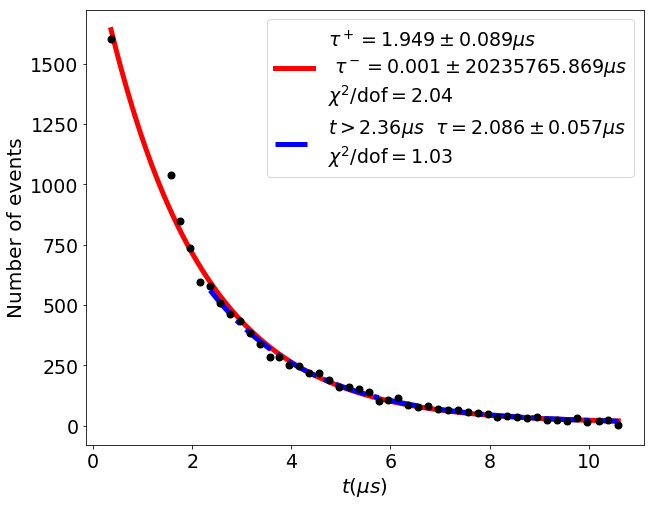

In [37]:
data2weekTOP = np.loadtxt('Muons2018/muon2wTOPnoB--00000.txt', delimiter = ';', skiprows = 5)
fig, ax = plt.subplots(1,1, figsize=(10,8))

__ = doTheDoubleFit(data2weekTOP,5, ax=ax)
__ = doTheFit(data2weekTOP,tail_threshold, ax=ax)
#tau_minus = ((1./tau_total) - (1./tau_plus))**-1
#print 'The NEGATIVE MUON lifetime obtained is %.3f mu s'%tau_minus
x= np.linspace(1e-7, 10e-6, 1000)

#ax.plot(x,5.10259278e+03*np.exp(-x/(2.2e-6)), label = '$\\tau = 2.2 \mu s$', lw=5)
#ax.plot(x,5.10259278e+03*np.exp(-x/(0.15e-6)), label = '$\\tau = 0.15 \mu s$', lw=5)
#ax.plot(x,5.10259278e+03*np.exp(-x*((2.2e-6)**-1 + (0.15e-6)**-1)), label = '$\\tau = total \mu s$', lw=5)
plt.legend(loc=0, fontsize=19)
plt.gcf()
plt.savefig('TopNoBDoubleExp.png', dpi=300)

# Fit data for $g$-factor

In [38]:
def g(w):
    B = ufloat(6.3e-3, 0.3e-3)
    return w*2*(206.8*m_e)/(e*B)

def doGFit(data, tau, guess = [1000.,3e6, 1./3, 1., 3.], th = 0,ax = ax, removeBkg=5, subs_bkg=False, correct = False):
    def f(x, a, w, d, e,b):
        return a*np.exp(x*(-tau)**-1)*(1.+d*np.cos(w*x-e)) + b
    y =data[th:,1]
    sy = sum(y)
    x= data[th:,0]
    dummy_y = np.copy(y)
    y=y[abs(dummy_y)!=0]
    x=x[abs(dummy_y)!=0]
    print x
    scale =1.
    bkg = sy*bkg_interpF(x)/scale
    if subs_bkg:
        y = np.copy(y)- bkg
        removeBkg = 0

    if correct:
        x, y = removeBackgroundPeaks(bkg, x, y, removeBkg)
    print 'The number of counts is %i'%(sum(y*scale))
    ax.plot(x*1e6,y, 'ok', markersize=7)

    popt, pcov = curve_fit(f, x, y, guess, method='lm')#, bounds=([0, 0, 0,-np.inf, 0], [np.inf, np.inf, 1.,np.inf, np.inf]))
    #print pcov
    perr = np.sqrt(np.diag(pcov))

    chisqd = chisq(y, f(x, *popt), len(guess))

    print 'Parameters: ', popt
    t = np.linspace(x[0], x[-1], 100)
    #print 'The muon lifetime obtained is %.3f mus'%(-popt[1]**-1 * 1e6)
    #print 'The Larmor frequency obtained is %.3f rad/s'%(popt[1])
    #print 'The g obtained is %.3f'%(abs(popt[1])*2*(206.8*m_e)/(e*4e-3))
    #print 'The background level is estimated to be %.2f of the total'%popt[-1]

    #ax.plot(x, bkg, 'ok')
    print 'Chi sq = %.3f'%chisq(y, f(x, *popt), len(guess))
    larmor_w = ufloat(popt[1], perr[1])
    obt_g = g(larmor_w)
    print obt_g
    ax.plot(t*1e6, f(t, *popt), label = '$\omega_L = (%.2f\pm %.2f)\\times 10^6  rad/s$\n$ g=%.3f\pm%.3f$\n$\chi^2/$dof$=%.2f$'%(popt[1]*1e-6, perr[1]*1e-6,obt_g.n, obt_g.s, chisqd), lw = 5)
    #ax.plot(t, popt[0]*np.exp(-t/(2.008e-6))*(1+popt[2]*np.cos(3.4e6*t)+popt[-2])+popt[-1])
    #ax.plot(t, popt[0]*np.exp(-t/(0.15e-6))+popt[-1])
    print 'The errors in the fit are ', perr
    [tick.label.set_fontsize(19) for tick in ax.xaxis.get_major_ticks()]
    [tick.label.set_fontsize(19) for tick in ax.yaxis.get_major_ticks()]
    plt.legend(loc=0, fontsize=19)
    ax.set_xlabel('$t(\mu s)$', fontsize=20)
    ax.set_ylabel('Number of events', fontsize=20)
    return 0

## Bottom

[2.12e-22 2.00e-07 4.00e-07 6.00e-07 8.00e-07 1.00e-06 1.20e-06 1.40e-06
 1.60e-06 1.80e-06 2.00e-06 2.20e-06 2.40e-06 2.60e-06 2.80e-06 3.00e-06
 3.20e-06 3.40e-06 3.60e-06 3.80e-06 4.00e-06 4.20e-06 4.40e-06 4.60e-06
 4.80e-06 5.00e-06 5.20e-06 5.40e-06 5.60e-06 5.80e-06 6.00e-06 6.20e-06
 6.40e-06 6.60e-06 6.80e-06 7.00e-06 7.20e-06 7.40e-06 7.60e-06 7.80e-06
 8.00e-06 8.20e-06 8.40e-06 8.60e-06 8.80e-06 9.00e-06 9.20e-06 9.40e-06
 9.60e-06 9.80e-06 1.00e-05 1.02e-05 1.04e-05]
The number of counts is 13868
Parameters:  [ 1.25522702e+03  1.82698699e+06  1.43129528e-01 -5.06622461e-01
  1.93732818e+01]
Chi sq = 2.244
0.68+/-0.06
The errors in the fit are  [2.29429659e+01 1.20345045e+05 1.36061000e-02 2.08478525e-01
 4.53388392e+00]
[1.80e-06 2.00e-06 2.20e-06 2.40e-06 2.60e-06 2.80e-06 3.00e-06 3.20e-06
 3.40e-06 3.60e-06 3.80e-06 4.00e-06 4.20e-06 4.40e-06 4.60e-06 4.80e-06
 5.00e-06 5.20e-06 5.40e-06 5.60e-06 5.80e-06 6.00e-06 6.20e-06 6.40e-06
 6.60e-06 6.80e-06 7.00e-06 7.20e-06 7

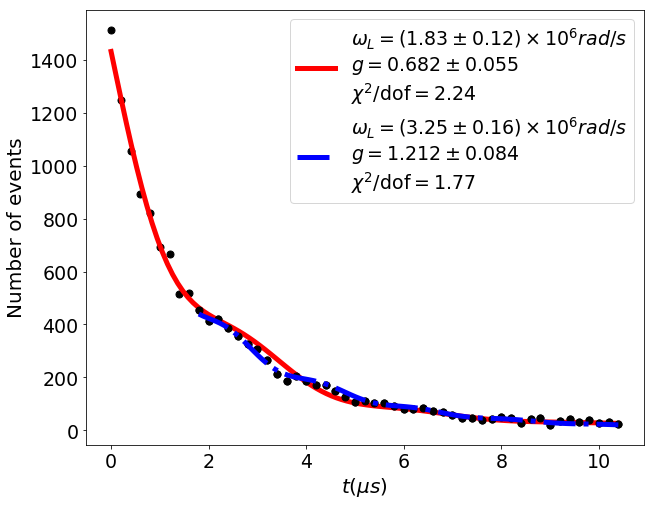

In [39]:
data_stop = np.loadtxt('Muons2018/muon1wBTOP--00001.txt',  delimiter = ';', skiprows = 5, dtype=float)
data_sbottom = np.loadtxt('Muons2018/muon1wBBOTTOM--00001.txt' , delimiter = ';', skiprows = 5, dtype=float)
fig, ax = plt.subplots(1,1, figsize = (10,8))
doGFit(data_sbottom, tau_sing_all,th = 0,ax = ax, removeBkg=0)
doGFit(data_sbottom, tau_sing_tail,th = tail_threshold,ax = ax, removeBkg=0)
plt.gcf()
plt.savefig('BottomWithB2in1.png', dpi=300)

[2.12e-22 2.00e-07 4.00e-07 6.00e-07 8.00e-07 1.00e-06 1.20e-06 1.40e-06
 1.60e-06 1.80e-06 2.00e-06 2.20e-06 2.40e-06 2.60e-06 2.80e-06 3.00e-06
 3.20e-06 3.40e-06 3.60e-06 3.80e-06 4.00e-06 4.20e-06 4.40e-06 4.60e-06
 4.80e-06 5.00e-06 5.20e-06 5.40e-06 5.60e-06 5.80e-06 6.00e-06 6.20e-06
 6.40e-06 6.60e-06 6.80e-06 7.00e-06 7.20e-06 7.40e-06 7.60e-06 7.80e-06
 8.00e-06 8.20e-06 8.40e-06 8.60e-06 8.80e-06 9.00e-06 9.20e-06 9.40e-06
 9.60e-06 9.80e-06 1.00e-05 1.02e-05 1.04e-05]
The number of counts is 13868
Parameters:  [ 1.25522702e+03  1.82698699e+06  1.43129528e-01 -5.06622461e-01
  1.93732818e+01]
Chi sq = 2.244
0.68+/-0.06
The errors in the fit are  [2.29429659e+01 1.20345045e+05 1.36061000e-02 2.08478525e-01
 4.53388392e+00]


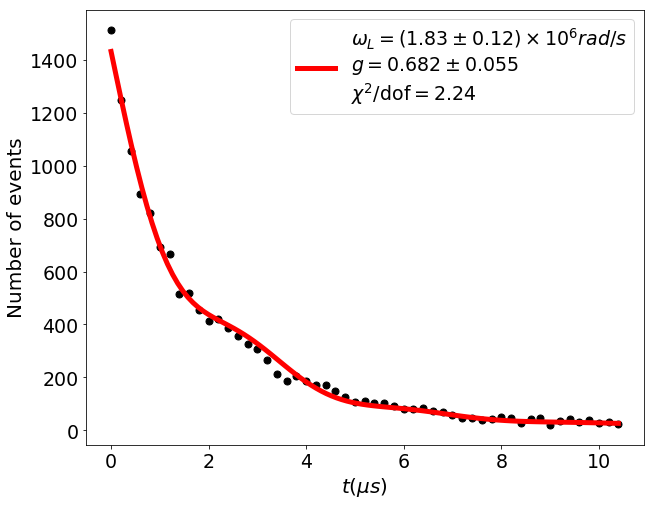

In [40]:
fig, ax = plt.subplots(1,1, figsize = (10,8))
doGFit(data_sbottom, tau_sing_all,th = 0,ax = ax)
plt.gcf()
plt.savefig('BottomWithB.png', dpi=300)

[1.80e-06 2.00e-06 2.20e-06 2.40e-06 2.60e-06 2.80e-06 3.00e-06 3.20e-06
 3.40e-06 3.60e-06 3.80e-06 4.00e-06 4.20e-06 4.40e-06 4.60e-06 4.80e-06
 5.00e-06 5.20e-06 5.40e-06 5.60e-06 5.80e-06 6.00e-06 6.20e-06 6.40e-06
 6.60e-06 6.80e-06 7.00e-06 7.20e-06 7.40e-06 7.60e-06 7.80e-06 8.00e-06
 8.20e-06 8.40e-06 8.60e-06 8.80e-06 9.00e-06 9.20e-06 9.40e-06 9.60e-06
 9.80e-06 1.00e-05 1.02e-05 1.04e-05]
The number of counts is 5943
Parameters:  [9.50984367e+02 3.24760025e+06 7.22778954e-02 1.88664954e+00
 6.16531238e+00]
Chi sq = 1.770
1.21+/-0.08
The errors in the fit are  [1.51872768e+01 1.63229425e+05 1.47412438e-02 5.27682542e-01
 2.53470050e+00]


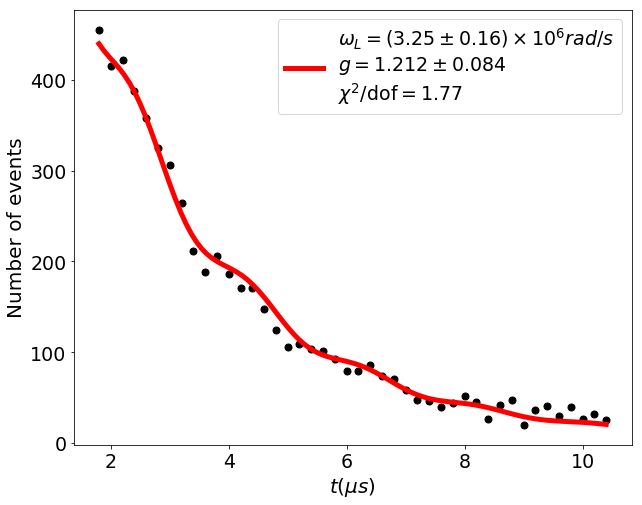

In [41]:

fig, ax = plt.subplots(1,1, figsize = (10,8))
doGFit(data_sbottom, tau_sing_tail,th = tail_threshold,ax = ax)
plt.savefig('BottomWithBTail.png', dpi=300)

## Top

[2.00e-07 4.00e-07 6.00e-07 8.00e-07 1.00e-06 1.20e-06 1.40e-06 1.60e-06
 1.80e-06 2.00e-06 2.20e-06 2.40e-06 2.60e-06 2.80e-06 3.00e-06 3.20e-06
 3.40e-06 3.60e-06 3.80e-06 4.00e-06 4.20e-06 4.40e-06 4.60e-06 4.80e-06
 5.00e-06 5.20e-06 5.40e-06 5.60e-06 5.80e-06 6.00e-06 6.20e-06 6.40e-06
 6.60e-06 6.80e-06 7.00e-06 7.20e-06 7.40e-06 7.60e-06 7.80e-06 8.00e-06
 8.20e-06 8.40e-06 8.60e-06 8.80e-06 9.00e-06 9.20e-06 9.40e-06 9.60e-06
 9.80e-06 1.00e-05 1.02e-05 1.04e-05]
The number of counts is 10367
Parameters:  [ 1.82561450e+03  3.69208125e+06 -7.72203775e-02  3.69184771e+00
  1.09259270e+01]
Chi sq = 1.109
1.38+/-0.07
The errors in the fit are  [1.87587068e+01 8.94464550e+04 1.14483751e-02 2.00674178e-01
 2.74926125e+00]
[2.20e-06 2.40e-06 2.60e-06 2.80e-06 3.00e-06 3.20e-06 3.40e-06 3.60e-06
 3.80e-06 4.00e-06 4.20e-06 4.40e-06 4.60e-06 4.80e-06 5.00e-06 5.20e-06
 5.40e-06 5.60e-06 5.80e-06 6.00e-06 6.20e-06 6.40e-06 6.60e-06 6.80e-06
 7.00e-06 7.20e-06 7.40e-06 7.60e-06 7.80e-06 8

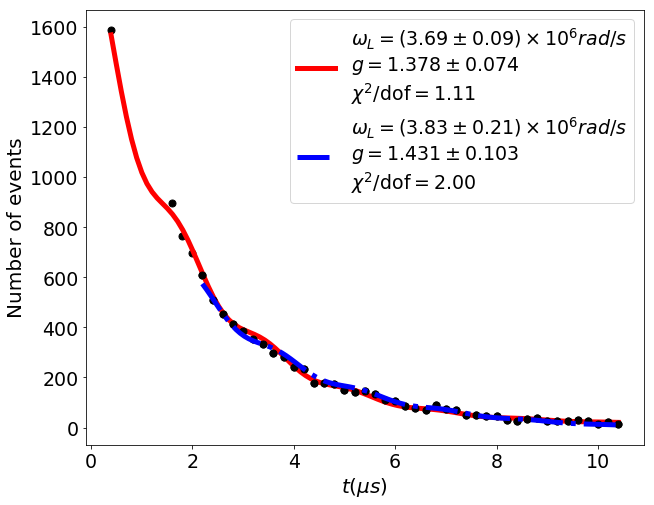

In [42]:
data_stop = np.loadtxt('Muons2018/muon1wBTOP--00001.txt',  delimiter = ';', skiprows = 7, dtype=float)
data_sbottom = np.loadtxt('Muons2018/muon1wBBOTTOM--00001.txt' , delimiter = ';', skiprows = 5, dtype=float)
fig, ax = plt.subplots(1,1, figsize = (10,8))
doGFit(data_stop, tau_sing_all,th = 0,ax = ax, correct=True, removeBkg=6)
doGFit(data_stop, tau_sing_tail,th = tail_threshold,ax = ax)
plt.gcf()
plt.savefig('TopWithB2in1.png', dpi=300)

# Other plots for report

In [43]:
def extractXY(data):
    return data[:,0], data[:,1]

## Raw initial data

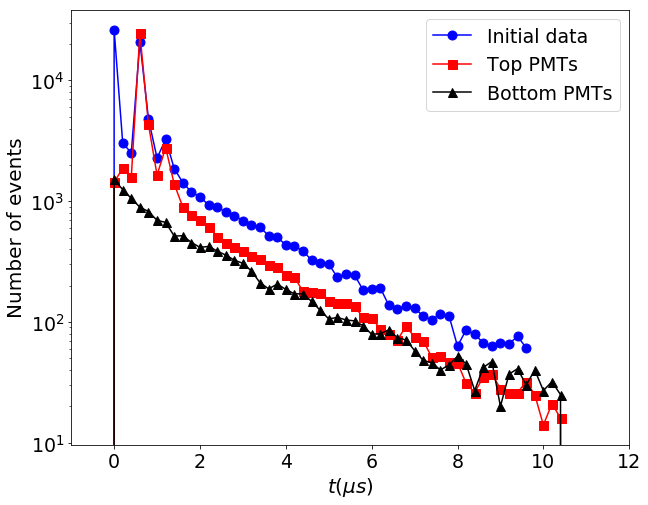

In [44]:
data2weekOK = np.loadtxt('Muons2018/muon2weekOK--00000.txt', delimiter = ';', skiprows = 5)
data_stop = np.loadtxt('Muons2018/muon1wBTOP--00001.txt',  delimiter = ';', skiprows = 5, dtype=float)
data_sbottom = np.loadtxt('Muons2018/muon1wBBOTTOM--00001.txt' , delimiter = ';', skiprows = 5, dtype=float)
fig, ax = plt.subplots(1,1, figsize=(10,8))
x_init = data2weekOK[:,0]
y_init = data2weekOK[:,1]
ax.plot(x_init*1e6, y_init, 'o-b', markersize = 9, label = 'Initial data')

x_top, y_top = data_stop[:,0], data_stop[:,1]
ax.plot(x_top*1e6, y_top, 's-r', markersize = 9, label = 'Top PMTs')

x_bottom, y_bottom = data_sbottom[:,0], data_sbottom[:,1]
ax.plot(x_bottom*1e6, y_bottom, '^-k', markersize = 9, label = 'Bottom PMTs')


ax.set_yscale('log')
plt.xlim(-1,12)
preetyPlot(ax)
plt.savefig('AllMeasurementsNoB.png', dpi=300)